In [1]:
"""
Questo script prende in input un file txt in cui sono salvate le inferenze calcolate dall'arduino nei vari test dei modelli di ML,
e confronta l'output dell'Arduino con quello riprodotto nell'audio di testing.

exptected è una lista di frames, ogni frame è un blocco temporale che contiene le informazioni di riproduzione del test audio
(ad esempio la categoria del suono riprodotto in quel momento)

i frame sono inseriti in una lista, per ogni inferenza contenuta nel file txt viene rintracciato il corrispettivo frame e viene confrontato
l'output dell'arduino con quello effettivamente riprodotto dal test. Vengono poi salvate le statistiche necessarie per lo studio del modello
che performa meglio.

"""
import os
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

class Frame:

    #per ogni frame salvo momento di inizio e fine)
    def __init__(self, startm, starts, endm, ends, type):

        self.start   = datetime.time(0,startm,starts)
        self.end     = datetime.time(0,endm,ends)
        self.type    = type

    def print(self):
        print("Sample type: " + self.type +" "+ str(self.start)+"-"+str(self.end))

class Inference:

    def __init__(self, startm, starts, endm, ends, type, confidence):

        self.start   = datetime.time(0,startm,starts)
        self.end     = datetime.time(0,endm,ends)
        self.type   = type

        if type == "F":
            self.Fconf = confidence
            self.Nconf = float("{:.3f}".format(1 - confidence))
        elif type == "N":
            self.Fconf = float("{:.3f}".format(1 - confidence))
            self.Nconf = confidence
        else:
            self.Fconf = 0
            self.Nconf = 0

    def print(self):
            print("Predicted: " + self.type +" "+ str(self.start)+"-"+str(self.end) + " Fire score: " + str(self.Fconf) + " Noise score: " + str(self.Nconf))

def avg(array):

    avg = 0.0
    for i in range (0, len(array),1):
        avg+=array[i]
    if len(array)!= 0:
        avg  = float("{:.3f}".format((float(avg/len(array)))))
    return avg

rexpected = []

frame = Frame(0,0,0,15,"Invalid")
rexpected.append(frame)
frame = Frame(0,16,2,15,"Noise") #uccelli
rexpected.append(frame)
frame = Frame(2,16,4,15,"Fire3") #uccelli + fuoco3
rexpected.append(frame)
frame = Frame(4,16,6,15,"Noise") #grilli
rexpected.append(frame)
frame = Frame(6,16,8,15,"Fire3") #grilli + fuoco3
rexpected.append(frame)
frame = Frame(8,16,10,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(10,16,12,15,"Noise") #Vento
rexpected.append(frame)
frame = Frame(12,16,14,15,"Noise") #uccelli
rexpected.append(frame)
frame = Frame(14,16,16,15,"Fire3") #uccelli + fuoco3
rexpected.append(frame)
frame = Frame(16,16,18,15,"Noise") #insetti
rexpected.append(frame)
frame = Frame(18,16,20,15,"Fire3") #insetti + fuoco3
rexpected.append(frame)
frame = Frame(20,16,22,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(22,16,24,15,"Noise") #vento
rexpected.append(frame)
frame = Frame(24,16,26,15,"Fire3") #Campfire
rexpected.append(frame)
frame = Frame(26,16,28,15,"Fire2") #uccelli + fuoco2
rexpected.append(frame)
frame = Frame(28,16,30,15,"Fire2") #uccelli + fuoco2
rexpected.append(frame)
frame = Frame(30,16,32,15,"Noise") #uccelli
rexpected.append(frame)
frame = Frame(32,16,34,15,"Noise") #insetti
rexpected.append(frame)
frame = Frame(34,16,36,15,"Fire3") #campfire
rexpected.append(frame)
frame = Frame(36,16,40,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(40,16,44,15,"Fire2") #insetti + fuoco2
rexpected.append(frame)
frame = Frame(44,16,46,15,"Noise") #vento
rexpected.append(frame)
frame = Frame(46,16,48,15,"Fire1") #uccelli + fuoco1
rexpected.append(frame)
frame = Frame(48,16,50,15,"Fire1") #uccelli + fuoco1
rexpected.append(frame)
frame = Frame(50,16,54,15,"Noise") #pioggia
rexpected.append(frame)
frame = Frame(54,16,58,15,"Fire1") #insetti + fuoco1
rexpected.append(frame)
frame = Frame(58,16,59,59,"Fire3") #Campfire
rexpected.append(frame)

inferences = []
file = "MFE-CONV2D-2C.txt" #filename to parse
!chmod +rwx MFE-CONV2D-2C.txt
#path = os.path.dirname(os.path.abspath(__file__))
#file = path + "/" + file
input = open(file,"r")

data = input.readlines()

for line in data:

    if line[0].isdigit():

        startmin = int(line[0:2])
        startsec = int(line[3:5])
        endmin   = int(line[6:8])
        endsec   = int(line[9:11])
        pred     = line[11]

        if pred == "D":
            score = 0
        else:
            score    = float("{:.3f}".format(float(line[13:18])))

        inf      = Inference(startmin, startsec, endmin, endsec, pred, score)
        inferences.append(inf)

    else:
        continue



frame_index=0

noise_results = [] #quante volte arduino ha previsto noise
fire_results  = [] #quante volte arduino ha previsto fuoco
invalid = [] #campioni registrati a cavallo tra un frame di un tipo e uno di un altro tipo
uncertain = []
max_consecutive_fire_while_fire = 0
max_consecutive_fire_while_noise = 0
consecutive_fire_while_fire = []
consecutive_fire_while_noise = []
last_consecutive_index = 0
consec_fire = 0

print("ROLLING FRAME FROM " + str(rexpected[frame_index].start) + " TO " + str(rexpected[frame_index].end))

for count, inf in enumerate(inferences):

    if inf.start>=rexpected[frame_index].end:
        while inf.start>=rexpected[frame_index].start:
            if inf.start<rexpected[frame_index].end or (inf.end<=rexpected[frame_index].end and inf.start>=rexpected[frame_index].start):
                break
            frame_index+=1
        consec_fire=1
        last_consecutive_index = count
        print("ROLLING FRAME FROM " + str(rexpected[frame_index].start) + " TO " + str(rexpected[frame_index].end) + " " + rexpected[frame_index].type )

    print("Inference: " + str(inf.start) + " to " + str(inf.end) + " " + inf.type)

    if (inf.start<rexpected[frame_index].end and inf.end>rexpected[frame_index].end) or rexpected[frame_index].type=="Invalid":
        tuple = ("Invalid", str(inf.start), str(inf.end))
        invalid.append(tuple)
    else:
        tuple = (rexpected[frame_index].type, inf.Fconf, inf.Nconf,str(inf.start),str(inf.end))
        if inf.type=="F":

            consec_fire = 1
            fire_results.append(tuple)

            if count>=last_consecutive_index:

                for i in range(0, len(inferences)-count-1,1):

                    last_consecutive_index += 1

                    if inferences[count+i+1].type == "F" and inferences[count+i+1].start<rexpected[frame_index].end:
                        consec_fire += 1

                    if  inferences[count+i+1].type != "F" or inferences[count+i+1].start>rexpected[frame_index].end or last_consecutive_index >= len(inferences)-1:
                        if rexpected[frame_index].type == "Fire1" or rexpected[frame_index].type == "Fire2" or rexpected[frame_index].type == "Fire3":
                            if consec_fire > max_consecutive_fire_while_fire:
                                max_consecutive_fire_while_fire=consec_fire
                            consecutive_fire_while_fire.append(consec_fire)
                        elif rexpected[frame_index].type == "Noise":
                            if consec_fire > max_consecutive_fire_while_noise:
                                max_consecutive_fire_while_noise=consec_fire
                            consecutive_fire_while_noise.append(consec_fire)
                        break



        elif inf.type=="N":
            noise_results.append(tuple)
            last_consecutive_index += 1
        elif inf.type=="D":
            uncertain.append(tuple)
            last_consecutive_index += 1
        if count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type != "Noise":
            consecutive_fire_while_fire.append(1)
        elif count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type == "Noise":
            consecutive_fire_while_noise.append(1)
#Di seguito le funzioni per calcolare le statistiche sulle inferenze del programma


inf_while_fire  = 0 #conta le inferenze totali fatte su audio di tipo fuoco
inf_while_noise = 0 # conta le inferenze totali fatte su audio di tipo noise
inf_while_fire1  = 0
inf_while_fire2  = 0
inf_while_fire3  = 0

noise_while_fire1 = 0

uncertain_while_fire  = 0
uncertain_while_noise = 0

avg_fire_while_fire    = []
avg_noise_while_noise  = []

avg_fire_while_fire3   = []
avg_fire_while_fire2   = []
avg_fire_while_fire1   = []

avg_noise_while_fire   = []
avg_fire_while_noise   = []

#calcolo le inferenze totali fatte su audio di tipo fuoco o noise
          
for i in range(0,len(fire_results),1):

    if fire_results[i][0] == "Fire1" or fire_results[i][0] == "Fire2" or fire_results[i][0] == "Fire3":
        
        inf_while_fire  += 1
        avg_fire_while_fire.append(fire_results[i][1])

        if fire_results[i][0] == "Fire1":
            inf_while_fire1  += 1
            avg_fire_while_fire1.append(fire_results[i][1])
        if fire_results[i][0] == "Fire2":
            inf_while_fire2+=1
            avg_fire_while_fire2.append(fire_results[i][1])
        if fire_results[i][0] == "Fire3":
            inf_while_fire3+=1
            avg_fire_while_fire3.append(fire_results[i][1])

    elif fire_results[i][0] == "Noise":
        
        inf_while_noise  += 1
        avg_fire_while_noise.append(fire_results[i][1])

for i in range(0,len(noise_results),1):

    if   noise_results[i][0] == "Fire1" or noise_results[i][0] == "Fire2" or noise_results[i][0] == "Fire3":
        
        inf_while_fire   += 1
        avg_noise_while_fire.append(noise_results[i][2])

        if noise_results[i][0] == "Fire1":
            inf_while_fire1+=1
            noise_while_fire1+=1
        if noise_results[i][0] == "Fire2":
            inf_while_fire2+=1
        if noise_results[i][0] == "Fire3":
            inf_while_fire3+=1

    elif noise_results[i][0] == "Noise":
        
        inf_while_noise += 1
        avg_noise_while_noise.append(noise_results[i][2])


for i in range(0,len(uncertain),1):

    if  uncertain[i][0] == "Fire1" or uncertain[i][0] == "Fire2" or uncertain[i][0] == "Fire3":
        inf_while_fire +=  1
        uncertain_while_fire += 1

    elif uncertain[i][0] == "Noise":
        inf_while_noise += 1
        uncertain_while_noise += 1

mean_fire_while_fire   = avg(avg_fire_while_fire)
mean_noise_while_noise = avg(avg_noise_while_noise)
mean_fire_while_fire1  = avg(avg_fire_while_fire1)
mean_fire_while_fire2  = avg(avg_fire_while_fire2)
mean_fire_while_fire3  = avg(avg_fire_while_fire3)
mean_noise_while_fire  = avg(avg_noise_while_fire)
mean_fire_while_noise  = avg(avg_fire_while_noise)

fire3_perc = 0
fire2_perc = 0
fire1_perc = 0
valid_perc = 0
good_fire_percentage = 0
bad_fire_percentage  = 0
good_noise_percentage = 0
bad_noise_percentage = 0
uncertain_percentage = 0
uncertain_fire_percentage = 0
uncertain_noise_percentage = 0

true_positives = len(avg_fire_while_fire)
true_positives_nof1 = len(avg_fire_while_fire) - len(avg_fire_while_fire1)
true_negatives = len(avg_noise_while_noise)
false_positives = len(avg_fire_while_noise)
false_negatives = len(avg_noise_while_fire)
false_negatives_nof1 = len(avg_noise_while_fire) - noise_while_fire1
tot_inferences     = len(inferences) #numero totale di inferenze (valide e non)
valid_inferences   = len(inferences)-len(invalid)

if tot_inferences != 0:
    valid_perc         = float("{:.1f}".format((valid_inferences/tot_inferences)*100))
if inf_while_fire != 0:
    fire_accuracy  = float("{:.1f}".format((true_positives/inf_while_fire)*100))
    fire_accuracy_nof1  = float("{:.1f}".format((true_positives_nof1/(inf_while_fire-inf_while_fire1))*100))
    false_negatives_percentage   = float("{:.1f}".format((false_negatives/inf_while_fire)*100))
    uncertain_fire_percentage  = float("{:.1f}".format((uncertain_while_fire/inf_while_fire)*100))
if inf_while_noise != 0:
    noise_accuracy = float("{:.1f}".format((true_negatives/inf_while_noise)*100))
    false_positives_percentage  = float("{:.1f}".format((false_positives/inf_while_noise)*100))
    uncertain_noise_percentage  = float("{:.1f}".format((float(uncertain_while_noise)/float(inf_while_noise))*100))
if valid_inferences != 0:
    uncertain_percentage  = float("{:.1f}".format((float(uncertain_while_fire + uncertain_while_noise)/float(valid_inferences))*100))
if (inf_while_fire + inf_while_noise) != 0:
    accuracy = float("{:.3f}".format(((true_positives + true_negatives)/(inf_while_fire + inf_while_noise))*100))
    accuracy_nof1 = float("{:.3f}".format((fire_accuracy_nof1+noise_accuracy)/2))
if (false_positives + false_negatives) !=0:
    recall = float("{:.3f}".format((true_positives/(true_positives+false_negatives))*100))
    recall_nof1 = float("{:.3f}".format((true_positives_nof1/(true_positives_nof1 + false_negatives_nof1))*100))
if (true_positives + false_positives) != 0:
    precision = float("{:.3f}".format((true_positives/(true_positives+false_positives))*100))
    precision_nof1 = float("{:.3f}".format((true_positives_nof1/(true_positives_nof1+false_positives))*100))
if recall != 0 and precision != 0:
    F1 = float("{:.3f}".format((2/((1/recall)+(1/precision)))))
    F1_nof1 = float("{:.3f}".format((2/((1/recall_nof1)+(1/precision_nof1)))))

if inf_while_fire3 != 0:
    fire3_perc         = float("{:.1f}".format((len(avg_fire_while_fire3)/inf_while_fire3)*100))
if inf_while_fire2 != 0:
    fire2_perc         = float("{:.1f}".format((len(avg_fire_while_fire2)/inf_while_fire2)*100))
if inf_while_fire1 != 0:
    fire1_perc         = float("{:.1f}".format((len(avg_fire_while_fire1)/inf_while_fire1)*100))

print("\n\nTotal inferences: " + str(tot_inferences) + "  Valid: " + str(valid_inferences) +"("+str(valid_perc)+"%)\n")#", "+ str(inf_while_fire)+ " while fire was playing and " + str(inf_while_noise) +" while noise was playing.")
print( "Accuracy:   " + str (accuracy_nof1) + " - Including ENT: " + str(accuracy) + "\nRecall:    " + str(recall_nof1)  + " - Including ENT: " + str(recall) + "\nPrecision: " + str(precision_nof1)  + " - Including ENT: " + str(precision) + "\nF1:        " + str(F1_nof1)  + " - Including ENT: " + str(F1) +"\n")
print("Fire Accuracy: " + str(true_positives_nof1)+"/"+str(inf_while_fire-inf_while_fire1)+"("+str(fire_accuracy_nof1) + "%) - Including ENT: " + str(true_positives)+"/"+str(inf_while_fire)+"("+str(fire_accuracy) + "%), mean confidence: " + str(mean_fire_while_fire)+ ", uncertain: " + str(uncertain_while_fire)+"("+str(uncertain_fire_percentage)+"%).")
print("False negatives:    " + str(false_negatives-noise_while_fire1)+ "("+ str(float("{:.1f}".format(((false_negatives-noise_while_fire1)/(inf_while_fire-inf_while_fire1))*100)))+ "%) - Including ENT: "+ str(false_negatives) + "("+str(false_negatives_percentage) + "%), mean confidence:" + str(mean_noise_while_fire)+ "\n")
print("Noise accuracy:  " + str(true_negatives)+"/"+str(inf_while_noise)+"("+ str(noise_accuracy) + "%), mean confidence: " + str(mean_noise_while_noise)+ ", uncertain: " + str(uncertain_while_noise)+"("+str(uncertain_noise_percentage)+"%).")
print("False positives: " +str(false_positives)+"("+ str(false_positives_percentage) + "%), mean confidence: " + str(mean_fire_while_noise)+"\n")
print("Fire volume dominance accuracy: " + str(len(avg_fire_while_fire3)) + "/" + str(inf_while_fire3) + "("+ str (fire3_perc)+"%), mean confidence: " + str (mean_fire_while_fire3))
print("Fire = Noise volume accuracy:  " + str(len(avg_fire_while_fire2)) + "/" + str(inf_while_fire2) + "("+ str (fire2_perc)+"%), mean confidence: " + str (mean_fire_while_fire2))
print("ENT accuracy: " + str(len(avg_fire_while_fire1)) + "/" + str(inf_while_fire1) + "("+ str (fire1_perc)+"%), mean confidence: " + str (mean_fire_while_fire1))

print("\nMax consecutive fire detections while playing fire: " + str(max_consecutive_fire_while_fire)+ " and mean consecutive fire detecionts while fire " + str(avg(consecutive_fire_while_fire)))
print("Max consecutive fire detections while playing noise: " + str(max_consecutive_fire_while_noise)+ " and mean consecutive fire detecionts while noise " + str(avg(consecutive_fire_while_noise)) + "\n\n")
#print(consecutive_fire_while_fire)
#print(consecutive_fire_while_noise)

#avg_fire_while_fire3   = []
#avg_fire_while_fire2   = []
#avg_fire_while_fire1   = []


ROLLING FRAME FROM 00:00:00 TO 00:00:15
ROLLING FRAME FROM 00:00:00 TO 00:00:15 Invalid
Inference: 00:08:11 to 00:00:01 N
Inference: 00:00:03 to 00:00:05 N
Inference: 00:00:06 to 00:00:08 N
Inference: 00:00:10 to 00:00:12 N
Inference: 00:00:13 to 00:00:15 N
ROLLING FRAME FROM 00:00:16 TO 00:02:15 Noise
Inference: 00:00:17 to 00:00:19 F
Inference: 00:00:20 to 00:00:22 N
Inference: 00:00:24 to 00:00:26 N
Inference: 00:00:28 to 00:00:30 N
Inference: 00:00:31 to 00:00:33 F
Inference: 00:00:35 to 00:00:37 N
Inference: 00:00:38 to 00:00:40 N
Inference: 00:00:42 to 00:00:44 F
Inference: 00:00:46 to 00:00:48 N
Inference: 00:00:49 to 00:00:51 F
Inference: 00:00:53 to 00:00:55 F
Inference: 00:00:56 to 00:00:58 F
Inference: 00:01:00 to 00:01:02 N
Inference: 00:01:04 to 00:01:05 N
Inference: 00:01:07 to 00:01:09 N
Inference: 00:01:11 to 00:01:13 F
Inference: 00:01:14 to 00:01:16 N
Inference: 00:01:18 to 00:01:20 N
Inference: 00:01:21 to 00:01:23 N
Inference: 00:01:25 to 00:01:27 N
Inference: 00:01

Inference: 00:30:16 to 00:30:18 N
Inference: 00:30:20 to 00:30:22 N
Inference: 00:30:23 to 00:30:25 N
Inference: 00:30:27 to 00:30:29 N
Inference: 00:30:30 to 00:30:32 N
Inference: 00:30:34 to 00:30:36 N
Inference: 00:30:38 to 00:30:40 N
Inference: 00:30:41 to 00:30:43 N
Inference: 00:30:45 to 00:30:47 N
Inference: 00:30:48 to 00:30:50 N
Inference: 00:30:52 to 00:30:54 N
Inference: 00:30:56 to 00:30:57 N
Inference: 00:30:59 to 00:31:01 N
Inference: 00:31:03 to 00:31:05 N
Inference: 00:31:06 to 00:31:08 N
Inference: 00:31:10 to 00:31:12 N
Inference: 00:31:13 to 00:31:15 N
Inference: 00:31:17 to 00:31:19 N
Inference: 00:31:21 to 00:31:23 N
Inference: 00:31:24 to 00:31:26 N
Inference: 00:31:28 to 00:31:30 N
Inference: 00:31:31 to 00:31:33 N
Inference: 00:31:35 to 00:31:37 N
Inference: 00:31:39 to 00:31:40 N
Inference: 00:31:42 to 00:31:44 N
Inference: 00:31:46 to 00:31:48 N
Inference: 00:31:49 to 00:31:51 N
Inference: 00:31:53 to 00:31:55 N
Inference: 00:31:56 to 00:31:58 N
Inference: 00:

Inference: 00:56:37 to 00:56:39 F
Inference: 00:56:40 to 00:56:42 F
Inference: 00:56:44 to 00:56:46 F
Inference: 00:56:47 to 00:56:49 F
Inference: 00:56:51 to 00:56:53 F
Inference: 00:56:55 to 00:56:57 N
Inference: 00:56:58 to 00:57:00 F
Inference: 00:57:02 to 00:57:04 F
Inference: 00:57:05 to 00:57:07 F
Inference: 00:57:09 to 00:57:11 F
Inference: 00:57:12 to 00:57:14 F
Inference: 00:57:16 to 00:57:18 F
Inference: 00:57:20 to 00:57:22 F
Inference: 00:57:23 to 00:57:25 N
Inference: 00:57:27 to 00:57:29 F
Inference: 00:57:30 to 00:57:32 F
Inference: 00:57:34 to 00:57:36 F
Inference: 00:57:38 to 00:57:40 F
Inference: 00:57:41 to 00:57:43 F
Inference: 00:57:45 to 00:57:47 N
Inference: 00:57:48 to 00:57:50 N
Inference: 00:57:52 to 00:57:54 F
Inference: 00:57:56 to 00:57:57 F
Inference: 00:57:59 to 00:58:01 D
Inference: 00:58:03 to 00:58:05 F
Inference: 00:58:06 to 00:58:08 N
Inference: 00:58:10 to 00:58:12 N
Inference: 00:58:13 to 00:58:15 N
ROLLING FRAME FROM 00:58:16 TO 00:59:59 Fire3
In

In [2]:
y_test = []
y_pred_proba = []

for i in range(0,len(inferences),1):
    if i <= len(fire_results)-1:
        if fire_results[i][0] == "Fire1" or fire_results[i][0] == "Fire2" or fire_results[i][0] == "Fire3":
            y_test.append(1)
            y_pred_proba.append(fire_results[i][1])
        elif fire_results[i][0] =="Noise":
            y_test.append(0)
            y_pred_proba.append(fire_results[i][1])
    if i<= len(noise_results)-1:
        if noise_results[i][0] == "Fire1" or noise_results[i][0] == "Fire2" or noise_results[i][0] == "Fire3":
            y_test.append(1)
            y_pred_proba.append(noise_results[i][1])
        elif noise_results[i][0] =="Noise":
            y_test.append(0)
            y_pred_proba.append(noise_results[i][1])
    if i> len(fire_results) and i>len(noise_results):
        break


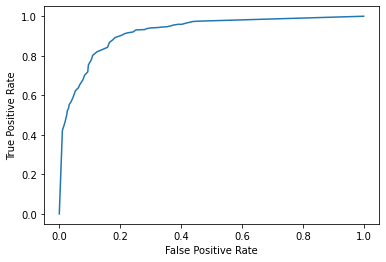

In [3]:
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

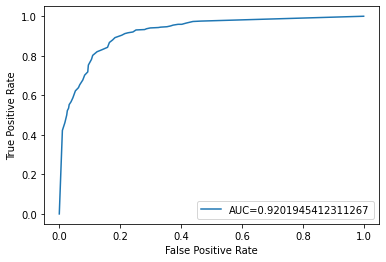

In [4]:
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [5]:
for i in range(0 , len(y_test),1):
    print (str(y_test[i]) + str(y_pred_proba[i]))

00.715
00.242
00.863
00.203
00.715
00.387
00.988
00.441
00.797
00.336
00.941
00.004
00.926
00.059
00.977
00.137
00.664
00.023
10.984
00.285
10.715
00.113
10.992
00.336
10.961
00.047
10.996
00.441
10.984
00.137
10.715
00.242
10.758
00.203
10.984
00.242
10.969
00.008
10.969
00.008
10.996
00.008
10.664
00.137
10.715
00.031
10.832
10.441
10.996
10.441
10.941
10.387
10.98
10.441
10.797
10.441
10.941
00.285
10.832
00.012
10.832
00.047
10.832
00.004
10.996
00.004
10.863
00.004
10.559
00.004
10.996
00.023
10.992
00.02
10.996
00.039
00.664
00.031
00.664
00.047
00.992
00.016
00.988
00.012
00.797
00.016
00.953
00.012
00.98
00.004
00.969
00.004
00.996
00.004
00.953
00.004
00.926
00.004
00.969
00.004
00.941
00.004
00.996
00.004
00.832
00.004
00.613
00.004
00.758
00.004
00.941
00.004
00.91
00.004
00.715
00.004
00.996
00.004
00.961
00.004
00.969
00.004
00.996
00.004
00.992
00.004
00.992
00.004
00.941
00.004
00.992
00.004
00.863
00.004
00.613
00.004
00.758
00.004
00.91
00.004
10.996
00.004
10.996
00.0